#Задание
Для того чтобы отслеживать, как выглядит путь клиента от знакомства с продуктом до его получения, и какие в нем есть проблемные места, аналитики часто строят воронки. Этот инструмент позволяет понять, сколько клиентов "теряется" на каждом из этапов процесса и сколько в итоге совершает целевое действие.

Перед вами схема данных проекта Тинькофф квест. Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Какие выводы можно сделать исходя из построенной воронки, какие точки роста продукта вы видите?

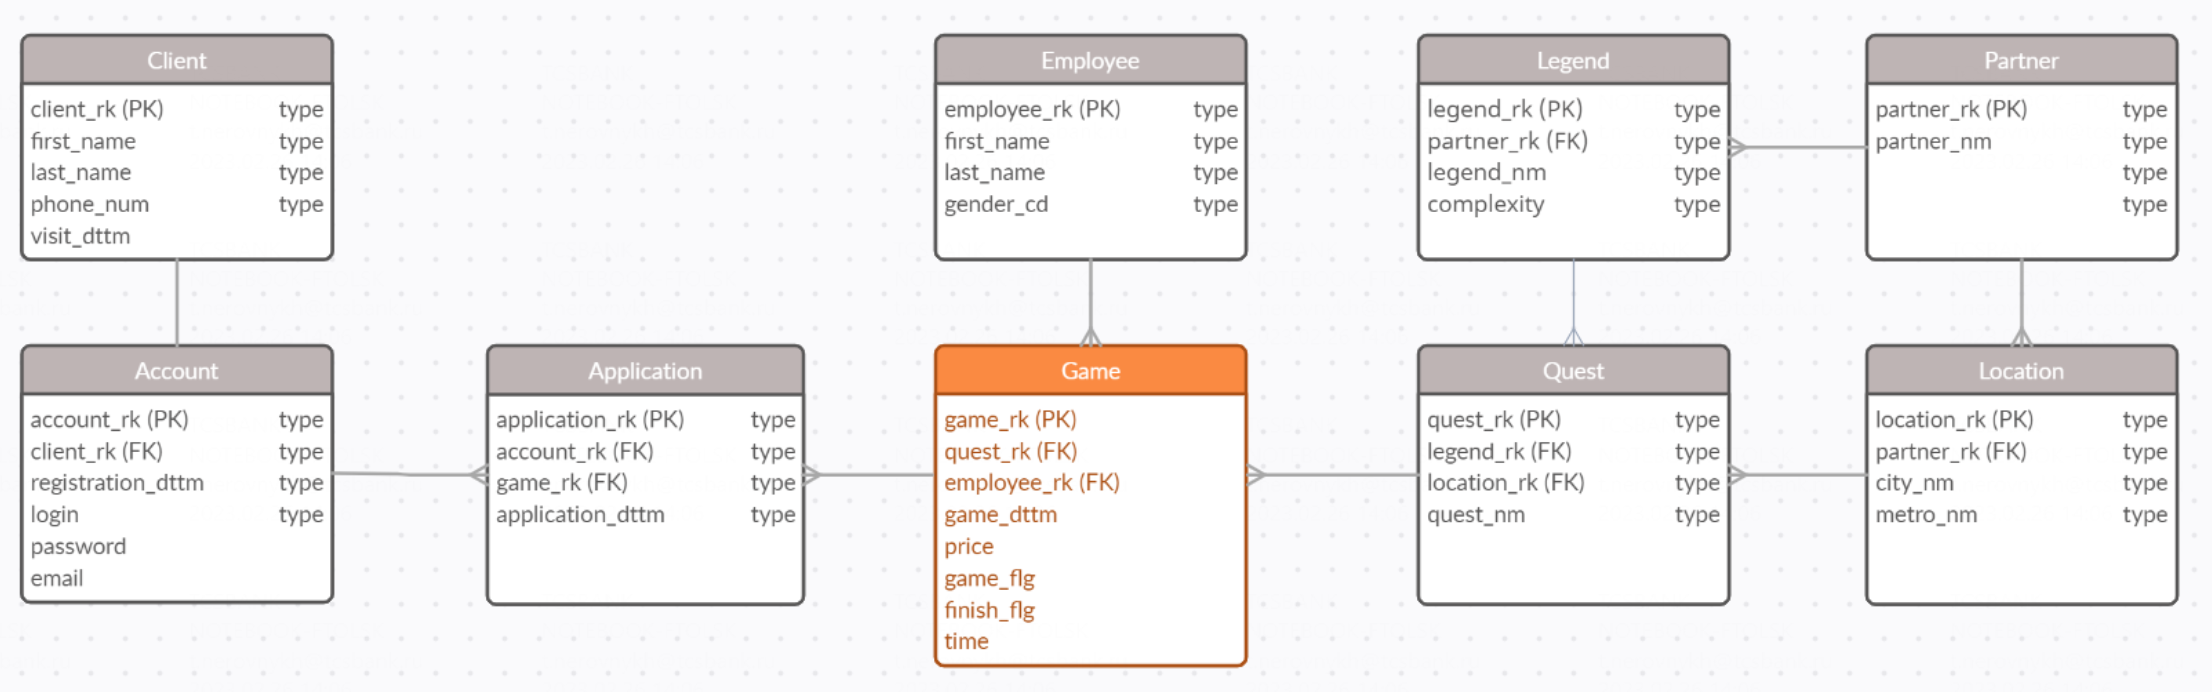

In [11]:
import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Подключение к серверу SQL

In [12]:
conn = psycopg2.connect(
    host="158.160.52.106",
    port=5432,
    database="postgres",
    user='student',
    password='JvLda93aA'
    )

#Создание фрейма данных по месяцам

In [13]:
df_visit = pd.read_sql("""
                      SELECT
                        count(*) as count_visit,
                        extract(month from visit_dttm) as month,
                        extract(year from visit_dttm) as year
                      FROM msu_analytics.client
                      GROUP BY year, month
                      ORDER BY year, month
                      """, conn).set_index(["month", "year"])
df_reg = pd.read_sql("""
                     SELECT
                       count(*) as count_reg,
                       extract(month from registration_dttm) as month,
                       extract(year from registration_dttm) as year
                     FROM msu_analytics.account
                     GROUP BY year, month
                     ORDER BY year, month
                    """, conn).set_index(["month", "year"])
df_app = pd.read_sql("""
                     SELECT
                        count(*) as count_app,
                        extract(month from application_dttm) as month,
                        extract(year from application_dttm) as year
                      FROM msu_analytics.application
                      GROUP BY year, month
                      ORDER BY year, month 
                    """, conn).set_index(["month", "year"])
df_game = pd.read_sql("""
                     SELECT
                        count(*) as count_game,
                        extract(month from game_dttm) as month,
                        extract(year from game_dttm) as year
                      FROM msu_analytics.game
                      WHERE game_flg = 1
                      GROUP BY year, month
                      ORDER BY year, month 
                    """, conn).set_index(["month", "year"])
df_month = df_visit.join([df_reg, df_app, df_game]).reset_index()
df_month['date'] =  df_month['month'].astype(int).astype(str) \
                            + '-' \
                            + df_month['year'].astype(int).astype(str)
df_month = df_month.drop(['month', 'year'], axis=1)
df_month = df_month.set_index('date')

df_month['count_reg_proc'] = round(df_month.count_reg / 
                           df_month.count_visit * 100, 2)
df_month['count_app_proc'] = round(df_month.count_app / 
                           df_month.count_visit * 100, 2)
df_month['count_game_proc'] = round(df_month.count_game / 
                           df_month.count_visit * 100, 2)
df_month

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

,count_visit,count_reg,count_app,count_game,count_reg_proc,count_app_proc,count_game_proc
date,,,,,,,
9-2022,778,186,63,2,23.91,8.10,0.26
10-2022,843,219,109,21,25.98,12.93,2.49
11-2022,786,195,107,43,24.81,13.61,5.47
12-2022,805,200,97,47,24.84,12.05,5.84
1-2023,852,215,133,63,25.23,15.61,7.39
2-2023,32,9,3,3,28.12,9.38,9.38


#Создание графика

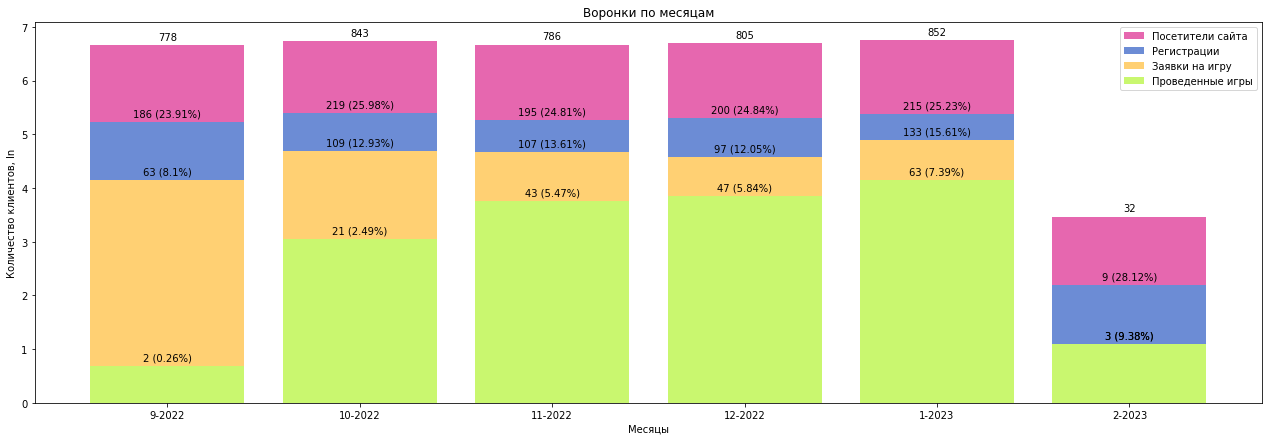

In [14]:
plt.figure(figsize=(22, 7))
graph = plt.bar(df_month.index, np.log(df_month.count_visit), color='#E667AF', label='Посетители сайта')
graph = plt.bar(df_month.index, np.log(df_month.count_reg), color='#6C8CD5', label='Регистрации')
graph = plt.bar(df_month.index, np.log(df_month.count_app), color='#FFD073', label='Заявки на игру')
graph = plt.bar(df_month.index, np.log(df_month.count_game), color='#C9F76F', label='Проведенные игры')
i = 0
for p in graph:
  plt.annotate(
          df_month.count_visit[i],
          ha='center',
          xy=(df_month.index[i], (np.log(df_month.count_visit[i]) + 0.1)))
  plt.annotate(
          df_month.count_reg[i].astype(str) + ' (' + 
            df_month.count_reg_proc[i].astype(str) + '%' + ')',
          ha='center',
          xy=(df_month.index[i], (np.log(df_month.count_reg[i]) + 0.1)))
  plt.annotate(
          df_month.count_app[i].astype(str) + ' (' + 
            df_month.count_app_proc[i].astype(str) + '%' + ')',
          ha='center',
          xy=(df_month.index[i], (np.log(df_month.count_app[i]) + 0.1)))
  plt.annotate(
          df_month.count_game[i].astype(str) + ' (' + 
            df_month.count_game_proc[i].astype(str) + '%' + ')',
          ha='center',
          xy=(df_month.index[i], (np.log(df_month.count_game[i]) + 0.1)))
  i += 1
plt.title("Воронки по месяцам")
plt.ylabel("Количество клиентов, ln")
plt.xlabel('Месяцы')
plt.legend()
plt.show()

#Создание фрейма данных по неделям

In [15]:
df_visit = pd.read_sql("""
                      SELECT 
                        count(*) as count_visit,
                        extract(week from visit_dttm) as week,
                        extract(year from visit_dttm) as year
                      FROM msu_analytics.client
                      GROUP BY year, week
                      ORDER BY year, week
                      """, conn).set_index(["week", "year"])
df_reg = pd.read_sql("""
                     SELECT
                       count(*) as count_reg,
                       extract(week from registration_dttm) as week,
                       extract(year from registration_dttm) as year
                     FROM msu_analytics.account
                     GROUP BY year, week
                     ORDER BY year, week
                    """, conn).set_index(["week", "year"])
df_app = pd.read_sql("""
                     SELECT
                        count(*) as count_app,
                        extract(week from application_dttm) as week,
                        extract(year from application_dttm) as year
                      FROM msu_analytics.application
                      GROUP BY year, week
                      ORDER BY year, week 
                    """, conn).set_index(["week", "year"])
df_game = pd.read_sql("""
                     SELECT
                        count(*) as count_game,
                        extract(week from game_dttm) as week,
                        extract(year from game_dttm) as year
                      FROM msu_analytics.game
                      WHERE game_flg = 1
                      GROUP BY year, week
                      ORDER BY year, week 
                    """, conn).set_index(["week", "year"])
df_week = df_visit.join([df_reg, df_app, df_game]).reset_index()
df_week['date'] =  df_week['week'].astype(int).astype(str) \
                            + '-' \
                            + df_week['year'].astype(int).astype(str)
df_week = df_week.drop(['week', 'year'], axis=1)
df_week.loc[18] += df_week.loc[23]
df_week.loc[18, 'date'] = '1-2023'
df_week = df_week.drop(index= 23 ).set_index('date')
df_week['count_reg_proc'] = round(df_week.count_reg / 
                          df_week.count_visit * 100, 2)
df_week['count_app_proc'] = round(df_week.count_app / 
                          df_week.count_visit * 100, 2)
df_week['count_game_proc'] = round(df_week.count_game / 
                           df_week.count_visit * 100, 2)

df_week

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

,count_visit,count_reg,count_app,count_game,count_reg_proc,count_app_proc,count_game_proc
date,,,,,,,
35-2022,111,22,NaN,NaN,19.82,NaN,NaN
36-2022,184,38,7.0,NaN,20.65,3.80,NaN
37-2022,167,42,17.0,1.0,25.15,10.18,0.60
38-2022,181,46,24.0,1.0,25.41,13.26,0.55
39-2022,195,56,18.0,1.0,28.72,9.23,0.51
40-2022,204,59,33.0,5.0,28.92,16.18,2.45
41-2022,190,46,28.0,3.0,24.21,14.74,1.58
42-2022,171,42,24.0,5.0,24.56,14.04,2.92
43-2022,189,48,18.0,7.0,25.40,9.52,3.70


Создание графика

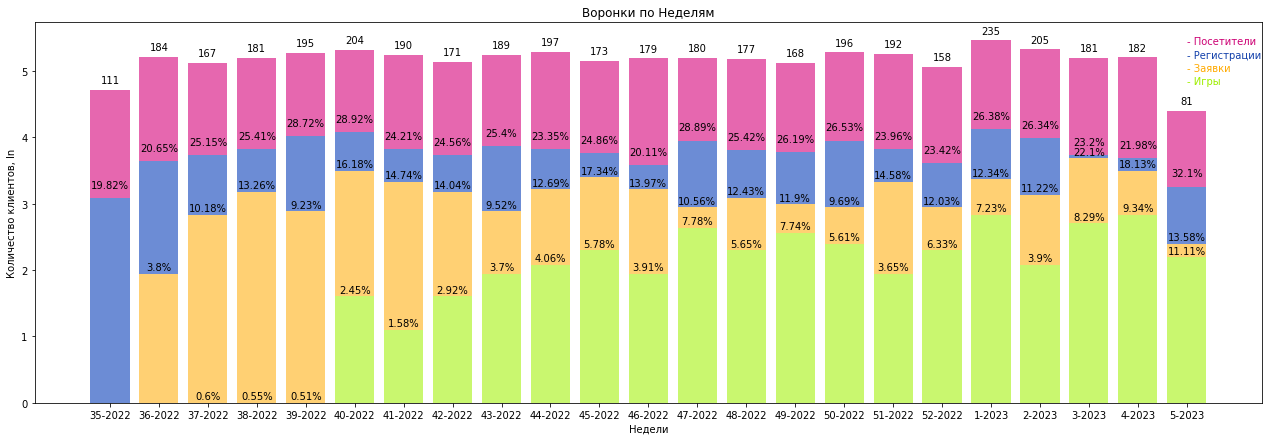

In [24]:
plt.figure(figsize=(22, 7))
graph = plt.bar(df_week.index, np.log(df_week.count_visit), color='#E667AF')
graph = plt.bar(df_week.index, np.log(df_week.count_reg), color='#6C8CD5')
graph = plt.bar(df_week.index, np.log(df_week.count_app), color='#FFD073')
graph = plt.bar(df_week.index, np.log(df_week.count_game), color='#C9F76F')
i = 0
for p in graph:
  plt.annotate(
          df_week.count_visit[i],
          ha='center',
          xy=(df_week.index[i], (np.log(df_week.count_visit[i]) + 0.1)))
  plt.annotate(
          df_week.count_reg_proc[i].astype(str) + '%',
          ha='center',
          xy=(df_week.index[i], (np.log(df_week.count_reg[i]) + 0.15)))
  plt.annotate(
          df_week.count_app_proc[i].astype(str) + '%',
          ha='center',
          xy=(df_week.index[i], (np.log(df_week.count_app[i]) + 0.05)))
  plt.annotate( 
          df_week.count_game_proc[i].astype(str) + '%',
          ha='center',
          xy=(df_week.index[i], (np.log(df_week.count_game[i]) + 0.05)))
  i += 1
plt.annotate('- Посетители',
             xy=(df_week.index[-1], 5.4),
             color='#CD0074')
plt.annotate('- Регистрации',
             xy=(df_week.index[-1], 5.2),
             color='#1240AB')
plt.annotate('- Заявки',
             xy=(df_week.index[-1], 5),
             color='#FFAA00')
plt.annotate('- Игры',
             xy=(df_week.index[-1], 4.8),
             color='#9FEE00')
plt.title("Воронки по Неделям")
plt.ylabel("Количество клиентов, ln")
plt.xlabel('Недели')
plt.show()

#Анализ воронок

In [17]:
reg_avg_week = df_week.count_reg_proc.mean()
reg_avg_week = round(100 - reg_avg_week,2)
reg_avg_month = df_month.count_reg_proc.mean()
reg_avg_month = round(100 - reg_avg_month,2)
reg_avg_week, reg_avg_month

(74.98, 74.52)

В среднем около 75% посетителей сайта не проходят регистрацию, это наиболее проблемный этап. Чтобы его исправить, нужно предложить пользователям более интригующие и интересные игры, на которые они точно захотели бы пойти

In [18]:
game_avg_week = round(((df_week.count_game / df_week.count_app) * 100).mean(), 2)
game_avg_month = round(((df_month.count_game / df_month.count_app) * 100).mean(), 2)
game_avg_week, game_avg_month

(37.07, 43.07)

Еженедельно около 37.07% клиентов от подавших заявку на игру, проходят квесты. Этот показатель еще больше в месячном эквиваленте - 43.07%. Это довольно большие показатели конверсии. Что свидетельствует о том, что клиенты не отказываются от игр, на которые подали заявки.

In [19]:
round(df_week.count_game_proc.mean(), 2), round(df_month.count_game_proc.mean(),2)

(4.89, 5.14)

Но лишь 5% от посетителей сайта доходят до финального этапа

In [20]:
df_week_new = df_week.drop(['count_reg_proc', 'count_app_proc', 'count_game_proc'], axis=1)
df_week_new.corr()

,count_visit,count_reg,count_app,count_game
count_visit,1.000000,0.871730,0.421164,0.071257
count_reg,0.871730,1.000000,0.297865,0.000059
count_app,0.421164,0.297865,1.000000,0.307840
count_game,0.071257,0.000059,0.307840,1.000000


In [21]:
df_month_new = df_month.drop(['count_reg_proc', 'count_app_proc', 'count_game_proc'], axis=1)
df_month_new.corr()

,count_visit,count_reg,count_app,count_game
count_visit,1.000000,0.997677,0.903794,0.559987
count_reg,0.997677,1.000000,0.921370,0.575283
count_app,0.903794,0.921370,1.000000,0.808152
count_game,0.559987,0.575283,0.808152,1.000000


Данные по корреляциям показывают, что необходимо увеличить взаимосвязь между зарегистрированными пользователями и пользователями, которые проходят квесты

In [22]:
ame_avg_week = round(((df_week.count_game / df_week.count_reg) * 100).mean(), 2)
game_avg_month = round(((df_month.count_game / df_month.count_reg) * 100).mean(), 2)
game_avg_week, game_avg_month

(37.07, 19.81)

И действительно в течение месяца почти 80% зарегистрированных пользователей не доходят до этапа проведения игры, следовательно нужно предлагать только что зарегистрированным пользователям заманчивые предложения, чтобы они активнее подавали заявки и участвовали в квестах